# Assignment 1

General Structure

    Parameters
    ----------
    A : str
        Element at the cube corners (A-site).
    B : str
        Element at the body center (B-site).
    c_to_a_ratio : float
        Ratio of c/a for the tetragonal phase.
    save_cifs : bool, optional
        If True, saves both structures as CIF files.
    show_widgets : bool, optional
        If True, displays 3D interactive structures using StructureWidget.

    Returns
    -------
    tuple[Structure, Structure]
        (cubic_perovskite, tetragonal_perovskite)



In [ ]:
from pymatgen.core import Lattice, Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatviz.widgets.structure import StructureWidget

#c_to_a_ratio=1.3
def generate_perovskites(A: str, B: str, c_to_a_ratio: float, save_cifs: bool = True, show_widgets: bool = True):
    # --- 1. Define lattice constants ---
    a = 4.0
    c = a * c_to_a_ratio

    # --- 2. Atomic positions ---
    frac_coords = [
        (0, 0, 0),               # A-site
        (0.5, 0.5, 0.5),         # B-site
        (0.5, 0.5, 0),           # O1
        (0.5, 0, 0.5),           # O2
        (0, 0.5, 0.5)            # O3
    ]
    species = [A, B, "O", "O", "O"]

    # --- 3. Create structures ---
    cubic = Structure(Lattice.cubic(a), species, frac_coords)
    tetragonal = Structure(Lattice.tetragonal(a, c), species, frac_coords)

    # --- 4. Space group analysis ---
    cubic_sg = SpacegroupAnalyzer(cubic).get_space_group_symbol()
    tetragonal_sg = SpacegroupAnalyzer(tetragonal).get_space_group_symbol()

    print(f"Cubic space group: {cubic_sg}")
    print(f"Tetragonal space group: {tetragonal_sg}")

    # --- 5. Save CIFs ---
    if save_cifs:
        cubic.to(fmt="cif", filename=f"{A}{B}O3_cubic.cif")
        tetragonal.to(fmt="cif", filename=f"{A}{B}O3_tetragonal.cif")
        print("CIF files saved = YES")

    return cubic, tetragonal


# EDITABLE PARAMETERS
# Able to change elements, c/a ratio, and whether to save .cif files
cperov, tperov = generate_perovskites("Ba", "Ti", 1.3, save_cifs=True, show_widgets=True)


Cubic space group: Pm-3m
Tetragonal space group: P4/mmm
CIF files saved = YES


In [5]:
from IPython.display import display
from pymatviz.widgets.structure import StructureWidget

print("🟩 Cubic Perovskite:")
display(StructureWidget(cperov))

print("⬛ Tetragonal Perovskite:")
display(StructureWidget(tperov))

🟩 Cubic Perovskite:


StructureWidget(structure={'@module': 'pymatgen.core.structure', '@class': 'Structure', 'charge': 0.0, 'lattic…

⬛ Tetragonal Perovskite:


StructureWidget(structure={'@module': 'pymatgen.core.structure', '@class': 'Structure', 'charge': 0.0, 'lattic…

#### **It appears as though the .cif files saved correctly.** 

#### The only differece between them is the **cell length c**, which should be the correct difference between the cubic and tetregonal structures.

#### Also, I wanted to print the cell structure using structure widget, for some reason only the **tetragonal** image appears but **not** the cubic. I do not know why at all

# Assignment 2

#### As you may or may not know, I have been using my own conda environment for the class thusfar. I spent a while on this assignment trying to update it to the mp_api packages, but there were some compadability issues with the dependent packages (between **typing extensions** and **Sentinal**). I eventually couldn't figure it out so I unstalled the ml4msd-files virtual environment

In [1]:
from mp_api.client import MPRester
from emmet.core.symmetry import CrystalSystem
from emmet.core.mpid import MPID
import matplotlib.pyplot as plt
from pymatviz.widgets.structure import StructureWidget
import pandas as pd

In [ ]:
from mp_api.client import MPRester
API_KEY = "5b2toNu5RX6WD7M8QREXXnGVb0C0WpEv"
with MPRester(API_KEY) as mpr:
    docs = mpr.materials.summary.search(
        is_metal=False,
        theoretical=False,
        fields=["material_id", "band_gap", "symmetry", "is_gap_direct"])
    data = docs
df = pd.DataFrame(docs)
#print (data) # prints list of MaterialSummaryDoc objects


Retrieving SummaryDoc documents:   0%|          | 0/27347 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x1171a34c0>
Traceback (most recent call last):
  File "/Users/coenradttaylor/Documents/GitHub/ML4MSD-HW-CoenradtT/.venv/lib/python3.11/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/coenradttaylor/Documents/GitHub/ML4MSD-HW-CoenradtT/.venv/lib/python3.11/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
  File "/Users/coenradttaylor/Documents/GitHub/ML4MSD-HW-CoenradtT/.venv/lib/python3.11/site-packages/tqdm/notebook.py", line 171, in display
    rtext.value = right
    ^^^^^^^^^^^
  File "/Users/coenradttaylor/Documents/GitHub/ML4MSD-HW-CoenradtT/.venv/lib/python3.11/site-packages/traitlets/traitlets.py", line 716, in __set__
    self.set(obj, value)
  File "/Users/coenradttaylor/Documents/GitHub/ML4MSD-HW-CoenradtT/.venv/lib/python3.11/site-packages/traitlets/traitlets.py", line 706, in set
    obj._notify_trait(self.name, old_value, new_value)
  

In [10]:
flattened = [
    {k: v for k, v in dict(d).items() if v is not None}
    for d in data]
mpids = pd.DataFrame.from_records(flattened)
mpids['symmetry.crystal_system'] = mpids['symmetry'].apply(
    lambda x: str(x.crystal_system).lower())
# drop columns that are all NaN
mpids = mpids.dropna(axis=1, how='all')
# drop `symmetry` (the full object) and `fields_not_requested`
mpids = mpids.drop(columns=['symmetry', 'fields_not_requested'], errors='ignore')
#mpids.to_csv('mp_hw3_data.csv', index=False)

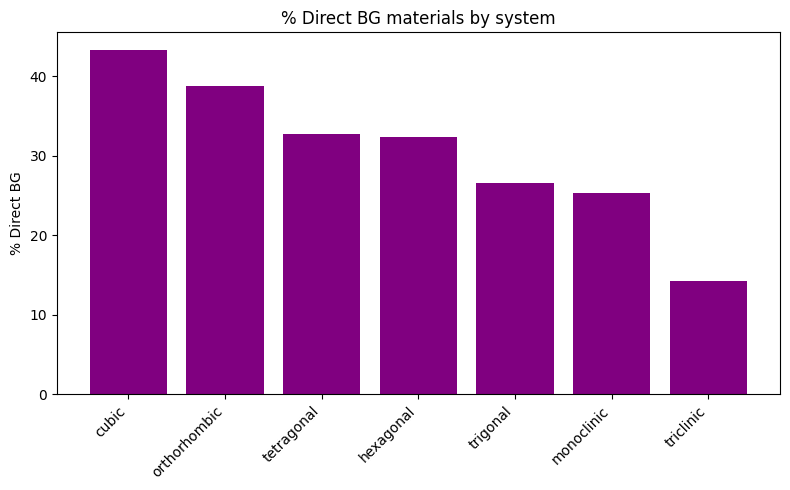

In [9]:
# DELETING INDIRECT BANDGAP
df = mpids.dropna(subset=['is_gap_direct'])
group = df.groupby('symmetry.crystal_system')

# Compute counts
count_total = group.size()
count_direct = group['is_gap_direct'].sum()  # boolean sum = number of True

# Compute percentage of direct-gap materials
pct_direct = 100 * count_direct / count_total

# Sort by percentage for nicer plotting
pct_direct = pct_direct.sort_values(ascending=False)

# Plot with Matplotlib
plt.figure(figsize=(8,5))
plt.bar(pct_direct.index, pct_direct.values, color='purple')
plt.xticks(rotation=45, ha='right')
plt.ylabel('% Direct BG')
plt.title('% Direct BG materials by system')
plt.tight_layout()
plt.show()


#### It is clear that the % of direct BG materials **decreases** with **increased** complexity of the crystal strucure. This makes sense, because simplicity/symmetry favors a direct BG, while more complex materials with less symmetry in their crystal structure have more of a chance ot have an indirect band gap

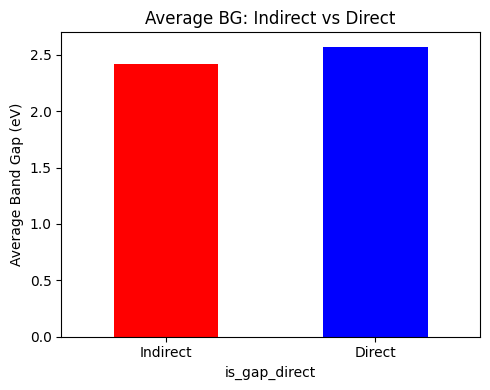

In [19]:
# Again, work with entries having is_gap_direct not null
df2 = mpids.dropna(subset=['is_gap_direct', 'band_gap'])

# Group by is_gap_direct (True vs False)
avg_bg = df2.groupby('is_gap_direct')['band_gap'].mean().rename({False: 'indirect', True: 'direct'})

# Turn into a simple bar plot
plt.figure(figsize=(5,4))
avg_bg.plot(kind='bar', color=['red', 'blue'])
plt.ylabel('Average Band Gap (eV)')
plt.xticks([0,1], ['Indirect', 'Direct'], rotation=0)
plt.title('Average BG: Indirect vs Direct')
plt.tight_layout()
plt.show()


#### The average BG between indirect and direct is **not** very different. This could be because we are including a *wide range* of materials in this plot, and specific differences will avergage out over a large dataset. It also could be a material property, the bandgap is dependent upon the chemistry of the material, which will not be vastly different for direct vs indirect materials

# Assignment 2

#### See Homework 3 folder

# Assignment 3

#### **Site**: a non-periodic site – a point in space with associated species (atom type) and optional properties (like magnetic moment).

#### **PeriodicSite**: extends Site to include a lattice, enabling periodic boundary conditions and correct distance calculations in crystals.

#### **OOP Methods**: Class (type of site), Object / Instance (sites), Inheritance (calls all relevant information from "site" into a "periodic site"), Composition (combination of sites + species to make a composition), etc...

#### **Dunder Methods**: __init__, __eq__, __contains__, __repr__, etc... lets us create, print, compare, and manipulate Site objects

#### This module represents atoms/sites in structures, with periodicity, defines classes that represent atomic sites in a crystal or molecular structure. Allows creation, comparison, manipulation of sites.